In [4]:
import py2neo
from py2neo import Node, Relationship, Graph, NodeMatcher
import pandas as pd
import time
import numpy as np

In [5]:
from absapi_aspect_class_prediction_engine import *

In [6]:
pred_engine()

absapi_aspect_class_prediction_engine.py loaded


In [10]:
#panda version
df=pd.read_csv("gbcfa_graphdata_with_aspects_clean.tsv", sep='\t',index_col = False, header=None, 
               names=["index","review_id","sentence_no","sentence","keyword","polarity","aspect_class"])
df.head() 

,index,review_id,sentence_no,sentence,keyword,polarity,aspect_class
0,NaN,2648,1,i love it but the operating system could use s...,operating system,0.0000,OS
1,0.0,2456,2,i bought the chromebook thinking that i will b...,connect,-0.3178,CONNECTIVITY
2,1.0,2456,2,i bought the chromebook thinking that i will b...,chromebook,-0.1589,LAPTOP
3,2.0,2456,3,"i could connect to citrix from my laptop, andr...",connect,0.0000,CONNECTIVITY
4,3.0,2456,3,"i could connect to citrix from my laptop, andr...",laptop,0.0000,LAPTOP


In [11]:
reviews_count=len( df["sentence_no"].unique())
# ((5000-reviews_count)/5000)*100
#out of 5000 reviews 
reviews_count

18802

In [12]:
len(df)
# .count()

34396

In [13]:
aspect_classes = df["aspect_class"].unique()
aspect_classes

array(['OS', 'CONNECTIVITY', 'LAPTOP', 'MEMORY', 'PERFORMANCE', 'DISPLAY',
       'KEYBOARD', 'SUPPORT', 'MULTIMEDIA', 'BATTERY', 'HARDDRIVE', 'FAN',
       'SHIPPING', 'CPU', 'OPTICAL_DRIVE', 'CHARGER', 'MOTHERBOARD'],
      dtype=object)

In [14]:
#Number of keywords detected in dataset
print("Number of keywords detected in dataset is :",len(df["keyword"].unique()))

Number of keywords detected in dataset is : 133


In [15]:
df.describe()

,index,review_id,sentence_no,polarity
count,34395.000000,34396.000000,34396.000000,34396.000000
mean,17197.000000,2175.264013,15380.644755,0.105294
std,9929.125591,1774.623743,8926.424402,0.233225
min,0.000000,0.000000,1.000000,-0.787600
25%,8598.500000,536.000000,7697.000000,0.000000
50%,17197.000000,1634.000000,15366.500000,0.000000
75%,25795.500000,4084.000000,23031.500000,0.226667
max,34394.000000,4999.000000,30991.000000,0.852908


<H1>BUILD GRAPH</h1>

In [25]:
#connect to neo4j
G= Graph("bolt://localhost:7687",password="gbcfa")

In [26]:
G.run('''match(n) return count(n)''').data()

[{'count(n)': 0}]

In [90]:
#unique keywords
# G.run('''

# //Constraints creation for users and services
# DROP CONSTRAINT ON (s:Review)
#        ASSERT s.review_id IS UNIQUE;
# ''')

# G.run('''
# DROP CONSTRAINT ON (u:Sentence)
#        ASSERT u.number IS UNIQUE

# ''')


# G.run('''
# DROP CONSTRAINT ON (u:Class)
#        ASSERT u.name IS UNIQUE

# ''')

# G.run('''
# DROP CONSTRAINT ON (u:Keyword)
#        ASSERT u.keyword IS UNIQUE

# ''')


In [91]:
#create constraints
# G.run('''

# //Constraints creation for users and services
# CREATE CONSTRAINT ON (s:Review)
#        ASSERT s.review_id IS UNIQUE;
# ''')

# G.run('''
# CREATE CONSTRAINT ON (u:Sentence)
#        ASSERT u.number IS UNIQUE

# ''')


# G.run('''
# CREATE CONSTRAINT ON (u:Class)
#        ASSERT u.name IS UNIQUE

# ''')

# G.run('''
# CREATE CONSTRAINT ON (u:Keyword)
#        ASSERT u.keyword IS UNIQUE

# ''')

In [28]:
# Create review nodes
n=0
# for rev in reviews.rdd.collect():
for index, row in df.iterrows():    
    n=n+1
    review_id = row["review_id"]
    G.run('''
    
    MERGE (rev:Review{review_id:$review_id})
    
    ''',parameters={'review_id':review_id}) 
                    
                    
print("Number of reviews created:", n)

Number of reviews created: 34396


In [29]:
# Create sentence nodes
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():  
    n = n+1
    sentence_no =  row["sentence_no"]
        
    sentence = row["sentence"]

    G.run(
        '''
    
    MERGE (sent:Sentence{number:$sentence_no, text:$sentence})
    
    ''', parameters={'sentence_no':sentence_no, "sentence":sentence})
                    
                    
print("Number of sentences created:", n)

Number of sentences created: 34396


In [32]:
#Create Aspect Class nodes 
n=0
# for cls in aspect_classes.rdd.collect():
for cls in aspect_classes:
#     print(cls)
    
#     CL = cls.aspect_class
    n = n + 1
    G.run(
    '''
    MERGE (class:Class{name:$class})
    
    ''', parameters={'class':cls}) 
print("Number of classes created:", n)

Number of classes created: 17


In [33]:
#Create keyword nodes
# aspect_classes = lbs
n=0

for aspect_class in aspect_classes:
    aspect_keywords=eval(aspect_class)
#     print(aspect_keywords)
    for keyword in aspect_keywords:
        n = n + 1
        G.run(
        '''
    
    MERGE (key:Keyword{keyword:$keyword})
    
    ''', parameters={'keyword':keyword})
                    
                    
print("Number of keywords created:", n)
        

Number of keywords created: 195


In [34]:
#Create [:BELONGS_TO ] relationships between keywords and ASPECT classes
aspect_classes = lbs
n=0

for aspect_class in aspect_classes:
    aspect_keywords=eval(aspect_class)
    for keyword in aspect_keywords:
        n = n + 1
        G.run(
        '''
    MATCH (key:Keyword{keyword:$keyword}),(class:Class{name:$class})
    MERGE (key)-[:BELONGS_TO]->(class)
    
    ''', parameters={'keyword':keyword,'class':aspect_class})
                    
                    
print("Number of [:BELONG_TO ] relationships created:", n)
            

Number of [:BELONG_TO ] relationships created: 195


In [35]:
# Create HAS_SENTENCE
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():    
    n = n+1
    sentence_no =  row["sentence_no"]
    review_id = row["review_id"]
        
#     sentence = row["sentence"]

    G.run(
        '''
    MATCH (rev:Review{review_id:$review_id}), (sent:Sentence{number:$sentence_no})
    MERGE (rev)-[:HAS_SENTENCE]->(sent)
    
    ''', parameters={'sentence_no':sentence_no, "review_id":review_id})
                    
                    
print("Number of sentences created:", n)

Number of sentences created: 34396


In [36]:
# Create HAS_OPINION_ON Relationship
# Create HAS_SENTENCE
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():  
    n = n+1
    sentence_no =  row["sentence_no"]
    keyword = row["keyword"]
    polarity = row["polarity"]
        
#     sentence = row["sentence"]

    G.run(
        '''
    MATCH (key:Keyword{keyword:$keyword}), (sent:Sentence{number:$sentence_no})
    MERGE (sent)-[:HAS_OPINION_ON{polarity:$polarity}]->(key)
    
    ''', parameters={'sentence_no':sentence_no, "keyword":keyword,'polarity':polarity})
                    
                    
print("Number of sentences created:", n)

Number of sentences created: 34396


In [38]:
# df.show(10)

In [39]:
'''   (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)- [o:HAS_OPINION_ON]->
(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class'''

'   (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)- [o:HAS_OPINION_ON]->\n(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class'

In [40]:
rev_class_bipartite = G.run(
    '''    MATCH (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)-[o:HAS_OPINION_ON]->(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class 
   '''
).data()


In [41]:
pd.DataFrame(rev_class_bipartite).head(5)

,rev,o,class
0,{'review_id': 111},{'polarity': -0.09866666666666668},{'name': 'OS'}
1,{'review_id': 111},{'polarity': 0.02573333333333333},{'name': 'OS'}
2,{'review_id': 1092},{'polarity': -0.2083},{'name': 'OS'}
3,{'review_id': 4195},{'polarity': 0.12726666666666667},{'name': 'OS'}
4,{'review_id': 4195},{'polarity': -0.13396666666666665},{'name': 'OS'}


In [42]:
import time
t0=time.time()
rev_projected =  G.run('''//class projection
MATCH 
 (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
WHERE class1<>class2
WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
return class1.name,class2.name,rev_intsct_count
   //return  rev.review_id,o.polarity,class.name
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
rev_projection = pd.DataFrame(rev_projected)

Time:  0.5970048904418945


In [43]:
import time
t0=time.time()
class_IDs =  G.run('''//class projection
MATCH 
 (class:Class)
 
 return ID(class) as id
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
class_IDs = pd.DataFrame(class_IDs)

Time:  0.01798248291015625


<h1>ANALYSIS STARTS HERE...............</h1>

In [44]:
import time
t0=time.time()
idd1=23185
class_IDs =  G.run('''//class projection
MATCH 
 (class:Class) 
 
 //where id(class)=$id
 
 return ID(class) as id
 ''',parameters={'id':idd1}).data()
t1=time.time()
print("Time: ", t1-t0)
print(class_IDs)
# class_IDs = pd.DataFrame(class_IDs)

Time:  0.008997678756713867
[{'id': 23185}, {'id': 23186}, {'id': 23187}, {'id': 23188}, {'id': 23189}, {'id': 23190}, {'id': 23191}, {'id': 23192}, {'id': 23193}, {'id': 23194}, {'id': 23195}, {'id': 23196}, {'id': 23197}, {'id': 23198}, {'id': 23199}, {'id': 23200}, {'id': 23201}]


In [45]:
class_IDs = pd.DataFrame(class_IDs)
id_list =list(class_IDs["id"])
id_list

[23185,
 23186,
 23187,
 23188,
 23189,
 23190,
 23191,
 23192,
 23193,
 23194,
 23195,
 23196,
 23197,
 23198,
 23199,
 23200,
 23201]

<h2>Most mentioned aspect class</h2>

In [46]:
most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
      return class1.name, count(o1) as counts order by counts desc''').data()

In [47]:
most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 12079},
 {'class1.name': 'OS', 'counts': 5674},
 {'class1.name': 'CONNECTIVITY', 'counts': 5037},
 {'class1.name': 'DISPLAY', 'counts': 2711},
 {'class1.name': 'PERFORMANCE', 'counts': 1789},
 {'class1.name': 'KEYBOARD', 'counts': 1574},
 {'class1.name': 'BATTERY', 'counts': 1372},
 {'class1.name': 'MULTIMEDIA', 'counts': 1354},
 {'class1.name': 'SUPPORT', 'counts': 720},
 {'class1.name': 'MEMORY', 'counts': 698},
 {'class1.name': 'HARDDRIVE', 'counts': 442},
 {'class1.name': 'FAN', 'counts': 402},
 {'class1.name': 'CPU', 'counts': 236},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 107},
 {'class1.name': 'SHIPPING', 'counts': 104},
 {'class1.name': 'CHARGER', 'counts': 92},
 {'class1.name': 'MOTHERBOARD', 'counts': 5}]

<h2>Most positive mentioned aspect class</h2>

In [48]:
pos_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity>0 return class1.name, count(o1) as counts order by counts desc''').data()

In [49]:
pos_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 6165},
 {'class1.name': 'OS', 'counts': 2300},
 {'class1.name': 'CONNECTIVITY', 'counts': 1962},
 {'class1.name': 'DISPLAY', 'counts': 1323},
 {'class1.name': 'KEYBOARD', 'counts': 979},
 {'class1.name': 'PERFORMANCE', 'counts': 928},
 {'class1.name': 'BATTERY', 'counts': 739},
 {'class1.name': 'MULTIMEDIA', 'counts': 637},
 {'class1.name': 'SUPPORT', 'counts': 278},
 {'class1.name': 'MEMORY', 'counts': 256},
 {'class1.name': 'FAN', 'counts': 153},
 {'class1.name': 'HARDDRIVE', 'counts': 148},
 {'class1.name': 'CPU', 'counts': 109},
 {'class1.name': 'SHIPPING', 'counts': 52},
 {'class1.name': 'CHARGER', 'counts': 35},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 34}]

<h2>Most negative mentioned aspect class</h2>

In [50]:
neg_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity<0 return class1.name, count(o1) as counts order by counts desc''').data()

In [51]:
neg_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 1739},
 {'class1.name': 'OS', 'counts': 970},
 {'class1.name': 'CONNECTIVITY', 'counts': 827},
 {'class1.name': 'DISPLAY', 'counts': 571},
 {'class1.name': 'KEYBOARD', 'counts': 240},
 {'class1.name': 'PERFORMANCE', 'counts': 233},
 {'class1.name': 'MULTIMEDIA', 'counts': 220},
 {'class1.name': 'SUPPORT', 'counts': 171},
 {'class1.name': 'BATTERY', 'counts': 160},
 {'class1.name': 'MEMORY', 'counts': 143},
 {'class1.name': 'HARDDRIVE', 'counts': 118},
 {'class1.name': 'FAN', 'counts': 104},
 {'class1.name': 'CPU', 'counts': 40},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 33},
 {'class1.name': 'CHARGER', 'counts': 26},
 {'class1.name': 'SHIPPING', 'counts': 22},
 {'class1.name': 'MOTHERBOARD', 'counts': 3}]

<h2>Most neutral mentioned aspect class</h2>

In [52]:
neu_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity=0 return class1.name, count(o1) as counts order by counts desc''').data()

In [53]:
neu_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 4175},
 {'class1.name': 'OS', 'counts': 2404},
 {'class1.name': 'CONNECTIVITY', 'counts': 2248},
 {'class1.name': 'DISPLAY', 'counts': 817},
 {'class1.name': 'PERFORMANCE', 'counts': 628},
 {'class1.name': 'MULTIMEDIA', 'counts': 497},
 {'class1.name': 'BATTERY', 'counts': 473},
 {'class1.name': 'KEYBOARD', 'counts': 355},
 {'class1.name': 'MEMORY', 'counts': 299},
 {'class1.name': 'SUPPORT', 'counts': 271},
 {'class1.name': 'HARDDRIVE', 'counts': 176},
 {'class1.name': 'FAN', 'counts': 145},
 {'class1.name': 'CPU', 'counts': 87},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 40},
 {'class1.name': 'CHARGER', 'counts': 31},
 {'class1.name': 'SHIPPING', 'counts': 30},
 {'class1.name': 'MOTHERBOARD', 'counts': 2}]

<h2>Generate Opinion Statistics for the 17 aspect classes of the product</h2>

In [54]:
aspect_class_opinion_stats=[]
id_list=list(class_IDs.id)

for ID in id_list:

    classid=ID
    all_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
            MATCH
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         //count(o1) as all_counts

         RETURN class.name as aspect_class, count(o1) as all_counts


         ''',parameters={'classid':classid}).data()

    neg_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity<0 

         RETURN count(o1) as neg_counts


         ''',parameters={'classid':classid}).data()

    pos_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity>0 

        RETURN count(o1) as pos_counts


         ''',parameters={'classid':classid}).data()

    neu_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity=0

         RETURN count(o1) as neu_counts


         ''',parameters={'classid':classid}).data()
    
    
    aspect_class_opinion_stats.append([all_opinions[0]['aspect_class'], all_opinions[0]['all_counts'],pos_opinions[0]['pos_counts'],pos_opinions[0]['pos_counts']/all_opinions[0]['all_counts']*100,neg_opinions[0]['neg_counts'],neg_opinions[0]['neg_counts']/all_opinions[0]['all_counts']*100, neu_opinions[0]['neu_counts'], neu_opinions[0]['neu_counts']/all_opinions[0]['all_counts']*100]
)

In [55]:
# [all_opinions[0]['aspect_class'], all_opinions[0]['all_counts'],pos_opinions[0]['pos_counts'],pos_opinions[0]['pos_counts']/all_opinions[0]['all_counts']*100,neg_opinions[0]['neg_counts'],neg_opinions[0]['neg_counts']/all_opinions[0]['all_counts']*100, neu_opinions[0]['neu_counts'], neu_opinions[0]['neu_counts']/all_opinions[0]['all_counts']*100]


ABSAPI_stats = pd.DataFrame(aspect_class_opinion_stats,columns=["aspect_class","all_counts","pos_counts","percent_pos","neg_counts","percent_neg","neu_counts","percent_neu"])



ABSAPI_stats.sort_values(['all_counts'], ascending=False)

,aspect_class,all_counts,pos_counts,percent_pos,neg_counts,percent_neg,neu_counts,percent_neu
2,LAPTOP,12079,6165,51.038993,1739,14.396887,4175,34.564120
0,OS,5674,2300,40.535777,970,17.095523,2404,42.368699
1,CONNECTIVITY,5037,1962,38.951757,827,16.418503,2248,44.629740
5,DISPLAY,2711,1323,48.801180,571,21.062339,817,30.136481
4,PERFORMANCE,1789,928,51.872554,233,13.024036,628,35.103410
6,KEYBOARD,1574,979,62.198221,240,15.247776,355,22.554003
9,BATTERY,1372,739,53.862974,160,11.661808,473,34.475219
8,MULTIMEDIA,1354,637,47.045790,220,16.248154,497,36.706056
7,SUPPORT,720,278,38.611111,171,23.750000,271,37.638889
3,MEMORY,698,256,36.676218,143,20.487106,299,42.836676


fig6


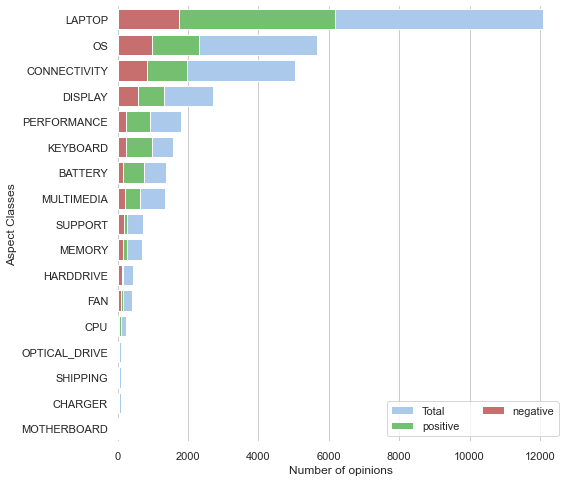

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))


data= ABSAPI_stats.sort_values(['all_counts'], ascending=False)
data= data[['aspect_class','all_counts','neu_counts','pos_counts', 'neg_counts']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_counts", y="aspect_class", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="pos_counts", y="aspect_class", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="neg_counts", y="aspect_class", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 12080), ylabel="Aspect Classes", xlabel="Number of opinions")
ax.set( ylabel="Aspect Classes", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)
print("fig6")

<h1>Keyword Stats</h1>

<h2>Generate Opinion Statistics for the top 20 aspect keywords of the product</h2>

In [57]:
import time
t0=time.time()

keyword_IDs =  G.run('''//class projection
MATCH  (s:Sentence)-[o:HAS_OPINION_ON]->(k:Keyword) 
  
 return distinct(ID(k)) as id
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
print(keyword_IDs)
# class_IDs = pd.DataFrame(class_IDs)


Time:  0.04799938201904297
[{'id': 23202}, {'id': 23203}, {'id': 23206}, {'id': 23207}, {'id': 23208}, {'id': 23209}, {'id': 23210}, {'id': 23211}, {'id': 23212}, {'id': 23215}, {'id': 23216}, {'id': 23217}, {'id': 23219}, {'id': 23220}, {'id': 23221}, {'id': 23222}, {'id': 23223}, {'id': 23224}, {'id': 23225}, {'id': 23226}, {'id': 23227}, {'id': 23228}, {'id': 23229}, {'id': 23231}, {'id': 23232}, {'id': 23233}, {'id': 23234}, {'id': 23235}, {'id': 23236}, {'id': 23237}, {'id': 23238}, {'id': 23239}, {'id': 23240}, {'id': 23242}, {'id': 23245}, {'id': 23246}, {'id': 23247}, {'id': 23248}, {'id': 23249}, {'id': 23250}, {'id': 23251}, {'id': 23254}, {'id': 23255}, {'id': 23256}, {'id': 23257}, {'id': 23258}, {'id': 23259}, {'id': 23260}, {'id': 23261}, {'id': 23262}, {'id': 23263}, {'id': 23264}, {'id': 23266}, {'id': 23267}, {'id': 23268}, {'id': 23270}, {'id': 23277}, {'id': 23278}, {'id': 23280}, {'id': 23281}, {'id': 23282}, {'id': 23284}, {'id': 23285}, {'id': 23286}, {'id': 23288

In [58]:

keyword_IDs = pd.DataFrame(keyword_IDs)
Key_id_list =list(keyword_IDs["id"])
# Key_id_list

In [59]:
keyword_opinion_stats=[]
for ID in Key_id_list:
    keyid=ID
    all_opinions=G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    //where co>0 
    return k.keyword as keyword,count(o.polarity) as all_counts''',parameters={'keyid':keyid}).data()
    
    neg_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity<0 
    return count(o.polarity) as neg_counts''',parameters={'keyid':keyid}).data()
    
    pos_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity>0 
    return count(o.polarity) as pos_counts''',parameters={'keyid':keyid}).data()
    
    neu_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity=0 
    return count(o.polarity) as neu_counts''',parameters={'keyid':keyid}).data()

    
#     print(allkey_counts)
    keyword_opinion_stats.append([all_opinions[0]['keyword'], all_opinions[0]['all_counts'],pos_opinions[0]['pos_counts'],neg_opinions[0]['neg_counts'],neu_opinions[0]['neu_counts']])
# keyword_opinion_stats    

In [60]:
Keyword_stats = pd.DataFrame(keyword_opinion_stats,columns=["keyword","all_counts","pos_counts","neg_counts","neu_counts"])



Keyword_stats=Keyword_stats.sort_values(['pos_counts'], ascending=False)

Keyword_stats20=Keyword_stats.head(20)
Keyword_stats20=Keyword_stats20.sort_values('all_counts', ascending=False)

figure7


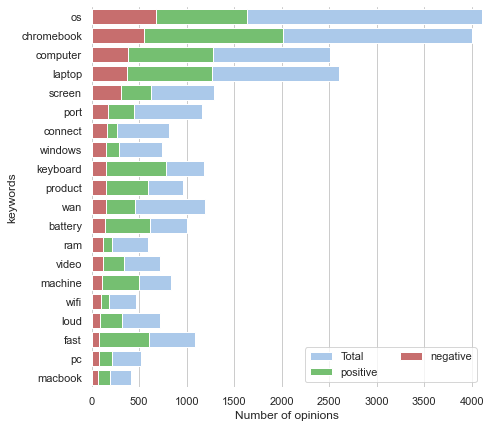

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))


data= Keyword_stats20.sort_values(['neg_counts'], ascending=False)
data= data[['keyword','all_counts','neu_counts','pos_counts', 'neg_counts']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_counts", y="keyword", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="pos_counts", y="keyword", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="neg_counts", y="keyword", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 4110), ylabel="keywords", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)
print("figure7")

<h2>Generate Opinion Statistics for the pairs of the top 20 aspect classes of the product</h2>

In [62]:
keynames=list(Keyword_stats20['keyword'])

keys=[]

# for key in keynames:
keywordids= G.run('''match (k:Keyword)
                    WHERE k.keyword IN $keynames 
                    RETURN ID(k) as keyid''',parameters={'keynames':keynames}).data()

#     keys



top20_keyword_ids=pd.DataFrame(keywordids)


In [63]:
key_id_list=list(top20_keyword_ids['keyid'])

key_co_mentions=[]
from itertools import combinations

key_id_pairs=[]

key_id_pairs=combinations(key_id_list, 2)
key_id_pairs


for comb in key_id_pairs:
    c=list(comb)
    keyword1_id= c[0]
    keyword2_id= c[1]
#     print(keyword1_id,keyword1_id)
    keyword_projection =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id
    WITH key1,key2, COUNT(DISTINCT(sent)) as sent_intsct_count
    RETURN  key1.keyword  as keywordA, key2.keyword as keywordB, sent_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    keyword_co_pos =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id AND o1.polarity>0 AND o2.polarity>0
    WITH key1,key2, COUNT(DISTINCT(sent)) as pos_intsct_count
    RETURN   pos_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    keyword_co_neg =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id AND o1.polarity>0 AND o2.polarity<0
    WITH key1,key2, COUNT(DISTINCT(sent)) as neg_intsct_count
    RETURN   key1,key2, neg_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    if len(keyword_projection)>0:
        
        if len(keyword_co_neg)==0:
            key_co_mentions.append([
                                keyword_projection[0]['keywordA'], 
                                keyword_projection[0]['keywordB'], 
                                keyword_projection[0]['sent_intsct_count'],
                                keyword_co_pos[0]['pos_intsct_count'],
                                0 ])
        else:
        

            key_co_mentions.append([
                                    keyword_projection[0]['keywordA'], 
                                    keyword_projection[0]['keywordB'], 
                                    keyword_projection[0]['sent_intsct_count'],
                                    keyword_co_pos[0]['pos_intsct_count'],
                                    keyword_co_neg[0]['neg_intsct_count']
            ])





In [65]:

Keyword_co_mentions_stats = pd.DataFrame(key_co_mentions,columns=["keyword1","keyword2","total","positive","negative"])
Keyword_co_mentions_stats.sort_values(["negative","total"], ascending=False).head(20)

,keyword1,keyword2,total,positive,negative
6,os,chromebook,662,212,26
5,os,laptop,500,179,19
112,chromebook,computer,326,128,17
3,os,port,244,75,14
119,chromebook,screen,156,54,14
0,os,windows,227,73,13
16,os,keyboard,227,107,12
100,laptop,computer,204,77,11
1,os,wifi,92,25,11
7,os,computer,447,153,9


In [66]:
Keyword_co_mentions_stats = pd.DataFrame(key_co_mentions,columns=["keyword1","keyword2","total","positive","negative"])
keypairstats=Keyword_co_mentions_stats.sort_values(["total","negative"], ascending=False).head(20)
keypairstats

,keyword1,keyword2,total,positive,negative
6,os,chromebook,662,212,26
5,os,laptop,500,179,19
7,os,computer,447,153,9
99,laptop,chromebook,389,139,9
15,os,video,359,135,5
112,chromebook,computer,326,128,17
3,os,port,244,75,14
14,os,screen,236,79,9
2,os,wan,231,69,6
0,os,windows,227,73,13


In [67]:
keypairstats["pairs"]=keypairstats["keyword1"] + "," + keypairstats["keyword2"] 
keypairstats

,keyword1,keyword2,total,positive,negative,pairs
6,os,chromebook,662,212,26,"os,chromebook"
5,os,laptop,500,179,19,"os,laptop"
7,os,computer,447,153,9,"os,computer"
99,laptop,chromebook,389,139,9,"laptop,chromebook"
15,os,video,359,135,5,"os,video"
112,chromebook,computer,326,128,17,"chromebook,computer"
3,os,port,244,75,14,"os,port"
14,os,screen,236,79,9,"os,screen"
2,os,wan,231,69,6,"os,wan"
0,os,windows,227,73,13,"os,windows"


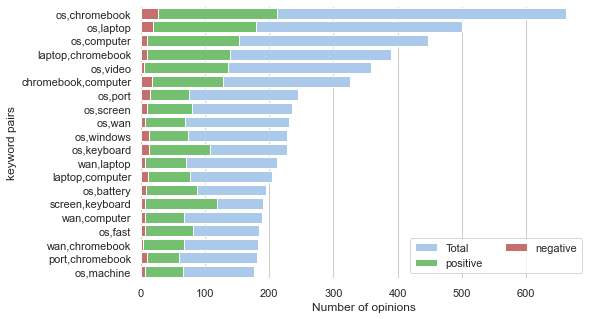

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))


# data= Keyword_stats20.sort_values(['all_counts'], ascending=False)
data= keypairstats[['total','positive','negative','pairs']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="pairs", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="positive", y="pairs", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="negative", y="pairs", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 665), ylabel="keyword pairs", xlabel="Number of opinions")
ax.set( ylabel="keyword pairs", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)

<H2>Top N aspect class co-mentions</H2>

In [71]:
id_list=list(class_IDs.id)

co_mentions=[]
from itertools import combinations

id_pairs=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1,class2)
    rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        co_mentions.append([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [72]:
len(co_mentions)

126

In [73]:
co_mentioned = pd.DataFrame(co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_co_mentioned = co_mentioned.sort_values('count', ascending=False)

N=10
sorted_co_mentioned.head(N)


,class1,class2,count
1,OS,LAPTOP,1632
16,CONNECTIVITY,LAPTOP,1534
0,OS,CONNECTIVITY,1106
33,LAPTOP,DISPLAY,1033
32,LAPTOP,PERFORMANCE,926
34,LAPTOP,KEYBOARD,801
4,OS,DISPLAY,776
37,LAPTOP,BATTERY,770
19,CONNECTIVITY,DISPLAY,706
3,OS,PERFORMANCE,668


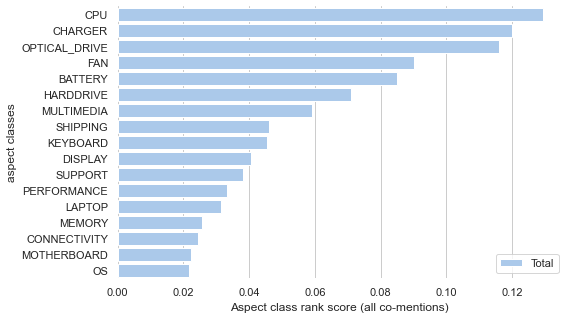

In [75]:
import networkx as nx
Dall=nx.DiGraph()
Dall.add_weighted_edges_from(co_mentions)
all_pagerank=nx.pagerank(Dall)

# all_pagerank

df_all_pagerank=pd.DataFrame.from_dict(all_pagerank,orient='index',columns=["rank"])
# df_negPageRank['aspect_class']=df_negPageRank.index
df_all_pagerank.reset_index(level=0, inplace=True)
df_all_pagerank=df_all_pagerank.rename(columns={'index':'aspect_class'})
df_all_pagerank=df_all_pagerank.sort_values('rank', ascending=False)
# df_all_pagerank

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# data=df_all_pagerank

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_all_pagerank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="aspect classes", xlabel="Aspect class rank score (all co-mentions) ")
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (all co-mentions) ")
sns.despine(left=True, bottom=True)

<H2>Top N negative aspect class co-mentoins</H2>

In [76]:
neg_co_mentions=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1_id,class2_id)
    neg_rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id and o1.polarity<0 and o2.polarity<0
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(neg_rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        neg_co_mentions.append([neg_rev_projected[0]["classA"],neg_rev_projected[0]["classB"],neg_rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [78]:
len(neg_co_mentions)

110

In [79]:
 neg_co_mentioned = pd.DataFrame( neg_co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_neg_co_mentioned =  neg_co_mentioned.sort_values('count', ascending=False)

N=10
sorted_neg_co_mentioned.head(N)

,class1,class2,count
1,OS,LAPTOP,264
15,CONNECTIVITY,LAPTOP,223
31,LAPTOP,DISPLAY,169
0,OS,CONNECTIVITY,146
4,OS,DISPLAY,108
32,LAPTOP,KEYBOARD,98
30,LAPTOP,PERFORMANCE,89
18,CONNECTIVITY,DISPLAY,84
34,LAPTOP,MULTIMEDIA,77
5,OS,KEYBOARD,74


<h3>Create negative co-mentioned projection of aspect classes</h3>
<h3>then compute weighted pagerank</h3>

In [80]:
import networkx as nx
D=nx.DiGraph()
D.add_weighted_edges_from(neg_co_mentions)
neg_pagerank=nx.pagerank(D)


# print(neg_pagerank)

In [81]:
type(neg_pagerank)

dict

In [82]:
df_negPageRank=pd.DataFrame.from_dict(neg_pagerank,orient='index',columns=["rank"])
df_negPageRank.reset_index(level=0, inplace=True)
df_negPageRank=df_negPageRank.rename(columns={'index':'aspect_class'})
df_negPageRank=df_negPageRank.sort_values('rank', ascending=False)

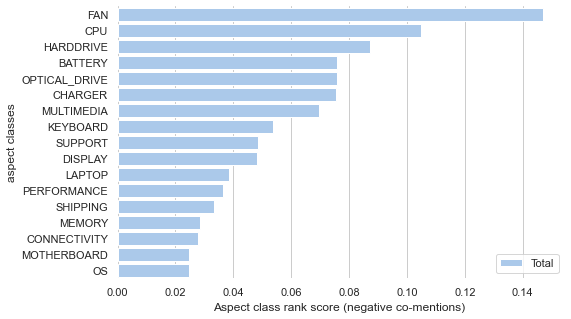

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_negPageRank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (negative co-mentions) ")
ax.set(ylabel="aspect classes", xlabel="Aspect class rank score (negative co-mentions) ")
sns.despine(left=True, bottom=True)

dd=pd.DataFrame(
[
['CONNECTIVITY', 0.024816891638914033],
 ['DISPLAY', 0.02698565012997087],
 ['SHIPPING', 0.025105722407523946],
 ['HARDDRIVE', 0.02724380807013692],
 ['CPU', 0.026713666999741606],
 ['MULTIMEDIA', 0.03371812833562775],
 ['OPTICAL_DRIVE', 0.026218567538212743],
 ['FAN', 0.031075395847498504],
 ['CHARGER', 0.026549134916688914],
 ['PERFORMANCE', 0.049653105376496205],
 ['BATTERY', 0.0519322981713498],
 ['KEYBOARD', 0.061616463789575415],
 ['MEMORY', 0.05102677552972876],
 ['OS', 0.12329533573094356],
 ['MOTHERBOARD',0.025058499734221088],
 ['SUPPORT',0.06912429432291131],
 ['LAPTOP',0.31986626146045866]
], columns=["Aspect class","ClassRank"])

<H2>Top N postive co-mentoins</H2>

In [84]:
pos_co_mentions=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1_id,class2_id)
    pos_rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id and o1.polarity>0 and o2.polarity>0
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(pos_rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        pos_co_mentions.append([pos_rev_projected[0]["classA"],pos_rev_projected[0]["classB"],pos_rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [85]:
len(pos_co_mentions)

118

In [86]:
pos_co_mentioned = pd.DataFrame( pos_co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_pos_co_mentioned =  pos_co_mentioned.sort_values('count', ascending=False)
# sorted_pos_co_mentioned.head(10)

In [87]:
Dp=nx.DiGraph()
Dp.add_weighted_edges_from(pos_co_mentions)
pos_pagerank=nx.pagerank(Dp)

# pos_pagerank

In [88]:
df_pos_pagerank=pd.DataFrame.from_dict(pos_pagerank,orient='index',columns=["rank"])
# df_negPageRank['aspect_class']=df_negPageRank.index
df_pos_pagerank.reset_index(level=0, inplace=True)
df_pos_pagerank=df_pos_pagerank.rename(columns={'index':'aspect_class'})
df_pos_pagerank=df_pos_pagerank.sort_values('rank', ascending=False)

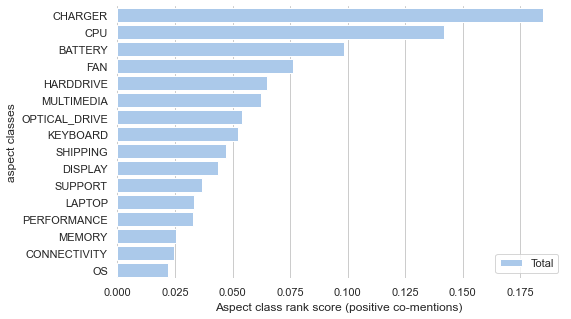

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# data=df_all_pagerank

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_pos_pagerank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="aspect classes", xlabel="Aspect class rank score (positive co-mentions) ")
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (positive co-mentions) ")
sns.despine(left=True, bottom=True)